In [1]:
import urllib
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [2]:
words = fetch_words_data()
print(type(words))
print(len(words))

<class 'list'>
17005207


In [ ]:
print(words[:5])

In [3]:
# https://gist.github.com/sebleier/554280
with open('./datasets/stopwords/NLTK_english_stopwords.txt', 'r') as f:
    lines = f.readlines()
stopwords = []
for line in lines:
    stopwords.append(line.split()[0])
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [4]:
words_without_stopwords = []
for word in words:
    if word not in stopwords:
        words_without_stopwords.append(word)
print(type(words_without_stopwords))
print(len(words_without_stopwords))       

<class 'list'>
10936403


In [5]:
words = words_without_stopwords 

In [6]:
print(words[:5])

['anarchism', 'originated', 'term', 'abuse', 'first']


In [7]:
import numpy as np
from collections import Counter

vocab_size = 50000

# vocabulary = [(word, count), ... ]
vocabulary = [("UNK", None)] + Counter(words).most_common(vocab_size - 1)
msg = 'Word  : {}\nCount : {}\n'
for v in vocabulary[:10]:
    print(msg.format(v[0], v[1]))

Word  : UNK
Count : None

Word  : one
Count : 411764

Word  : zero
Count : 264975

Word  : nine
Count : 250430

Word  : two
Count : 192644

Word  : eight
Count : 125285

Word  : five
Count : 115789

Word  : three
Count : 114775

Word  : four
Count : 108182

Word  : six
Count : 102145



In [8]:
# vocab = np.array([word, ... ])
# vocab_count = np.array([count, ... ])
vocab = np.array([word for word, _ in vocabulary])
vocab_count = np.array([word_count for _, word_count in vocabulary])

# word2idx = {word: idx} 
# idx2word = {idx: word}
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [9]:
words_idx = np.array([word2idx.get(word, 0) for word in words])
print(type(words_idx))
print(words_idx.shape)
print(words_idx[0])
print(words_idx[1])

<class 'numpy.ndarray'>
(10936403,)
5115
2963


In [10]:
print(words[24])
print(words_idx[24])

describe
1209


In [11]:
print(" ".join(words[:10]))
print(words_idx[:10])

anarchism originated term abuse first used early working class radicals
[ 5115  2963   109  3016    12    15    54   632   373 10451]


In [12]:
word_idx_list = [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]
print(" ".join([idx2word[word_idx] for word_idx in word_idx_list]))

spirits agave first five central zero seasons later including


In [13]:
from collections import deque

def generate_batch(batch_size=128, num_skips=2, skip_window=1):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    context_batch = np.ndarray(shape=[batch_size], dtype=np.int32) # fix memory
    target_batch = np.ndarray(shape=[batch_size, 1], dtype=np.int32)     # fix memory
    span = 2 * skip_window + 1 # len of [ skip_window target skip_window ]
    buffer = deque(maxlen=span)                            # [skip_window_word, target_word, skip_window_word]
    for _ in range(span):                                  # [skip_window_word, target_word, skip_window_word]
        buffer.append(words_idx[data_index])               # [skip_window_word, target_word, skip_window_word]
        data_index = (data_index + 1) % words_idx.shape[0] # [skip_window_word, target_word, skip_window_word]
    for i in range(batch_size // num_skips):
        # target_word is used num_skips times in batch  
        target_word = buffer[skip_window] 
        context_idx_to_avoid = [ skip_window ] # target_word at the center of the buffer
        context_idx = skip_window 
        for j in range(num_skips):
            while context_idx in context_idx_to_avoid:
                context_idx = np.random.randint(0, span)
            context_word = buffer[context_idx]
            context_idx_to_avoid.append(context_idx)
            context_batch[i * num_skips + j] = context_word
            target_batch[i * num_skips + j, 0] =  target_word
        buffer.append(words_idx[data_index])               # append next word to buffer
        data_index = (data_index + 1) % words_idx.shape[0] # append next word to buffer
    return context_batch, target_batch

In [14]:
np.random.seed(42)

In [15]:
data_index = 0
context_batch, target_batch = generate_batch(batch_size=8, num_skips=2, skip_window=1)

In [16]:
print(context_batch)
print([idx2word[idx] for idx in context_batch])

[ 109 5115 3016 2963  109   12   15 3016]
['term', 'anarchism', 'abuse', 'originated', 'term', 'first', 'used', 'abuse']


In [17]:
print(target_batch)
print([idx2word[idx] for idx in target_batch[:, 0]])

[[2963]
 [2963]
 [ 109]
 [ 109]
 [3016]
 [3016]
 [  12]
 [  12]]
['originated', 'originated', 'term', 'term', 'abuse', 'abuse', 'first', 'first']


In [18]:
import tensorflow as tf
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [19]:
lr = 0.01
epoch = int(1e4)
batch_size = 128
n_negative_samples = 64   

In [20]:
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

In [21]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(np.arange(1,valid_window), valid_size, replace=False)
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [22]:
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')
init_b = tf.keras.initializers.zeros()

In [23]:
x = tf.placeholder(tf.int32, shape=[None]) # placehoder for context_batch
y = tf.placeholder(tf.int32, shape=[None, 1]) # placehoder for target_batch

In [24]:
vocab_size = 50000
embedding_size = 150
E = tf.get_variable('embeddings', [vocab_size, embedding_size], tf.float32, init_w)
embedded_x = tf.nn.embedding_lookup(E, x)

In [25]:
print(x)
print(embedded_x)

Tensor("Placeholder:0", shape=(?,), dtype=int32)
Tensor("embedding_lookup/Identity:0", shape=(?, 150), dtype=float32)


In [26]:
nce_w = tf.get_variable('nce_w', [vocab_size, embedding_size], tf.float32, init_w)
nce_b = tf.get_variable('nce_b', [vocab_size], tf.float32, init_b)
nce_loss = tf.nn.nce_loss(nce_w, nce_b, 
                          y, embedded_x,
                          n_negative_samples, vocab_size)
loss = tf.reduce_mean(nce_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

In [28]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(E), axis=1, keepdims=True))
normalized_E = E / norm
valid_E = tf.nn.embedding_lookup(normalized_E, valid_dataset)
similarity = tf.matmul(valid_E, normalized_E, transpose_b=True)

In [34]:
print(valid_E)
print(normalized_E)
print(similarity)

Tensor("embedding_lookup_1/Identity:0", shape=(16, 150), dtype=float32)
Tensor("truediv:0", shape=(50000, 150), dtype=float32)
Tensor("MatMul_1:0", shape=(16, 50000), dtype=float32)


In [29]:
init = tf.global_variables_initializer()

In [30]:
with tf.Session() as session:
    init.run()
    
    loss_trace = []

    gradient_step = 0
    for _ in range(epoch):
        context_batch, target_batch = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {x: context_batch, y: target_batch}
        _, loss_run = session.run([train, loss], feed_dict=feed_dict)
        loss_trace.append(loss_run)
        gradient_step += 1

        if gradient_step % 1000 == 0:
            print('Gradient Step : {}'.format(gradient_step))
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocab[valid_examples[i]]
                top_k = 5 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Near to {}: ".format(valid_word)
                for k in range(top_k):
                    log_str += vocab[nearest[k]] + ', '
                log_str = log_str[:-2]
                print(log_str)

    final_embeddings = normalized_E.eval()

Gradient Step : 1000
Near to people: us, strike, helped, interpreted, fought
Near to external: sea, visible, phoenix, settlers, fiction
Near to nine: section, eight, four, seven, early
Near to british: croatians, alchemists, aeronautical, assignments, atc
Near to n: acts, rd, approximately, federation, russia
Near to set: followers, alchemist, village, go, alchemical
Near to time: moment, spirit, good, era, indigenous
Near to french: behavioral, hugo, capture, highest, say
Near to life: senses, seems, seemed, albert, adult
Near to south: alchemical, distillation, ethnography, pago, purifying
Near to early: seven, isbn, million, january, late
Near to common: heritage, methods, convincing, normally, ability
Near to could: amount, using, everyone, beginning, ascii
Near to new: failure, harmony, internal, failed, lack
Near to four: five, seven, isbn, three, million
Near to called: though, peter, country, lives, interpretations
Gradient Step : 2000
Near to people: covered, advocates, method

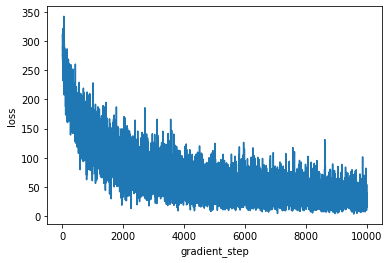

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_trace)
plt.xlabel('gradient_step')
plt.ylabel('loss')
plt.show()

In [35]:
os.makedirs('./save', exist_ok=True)
np.save("./save/my_final_embeddings.npy", final_embeddings)

In [51]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

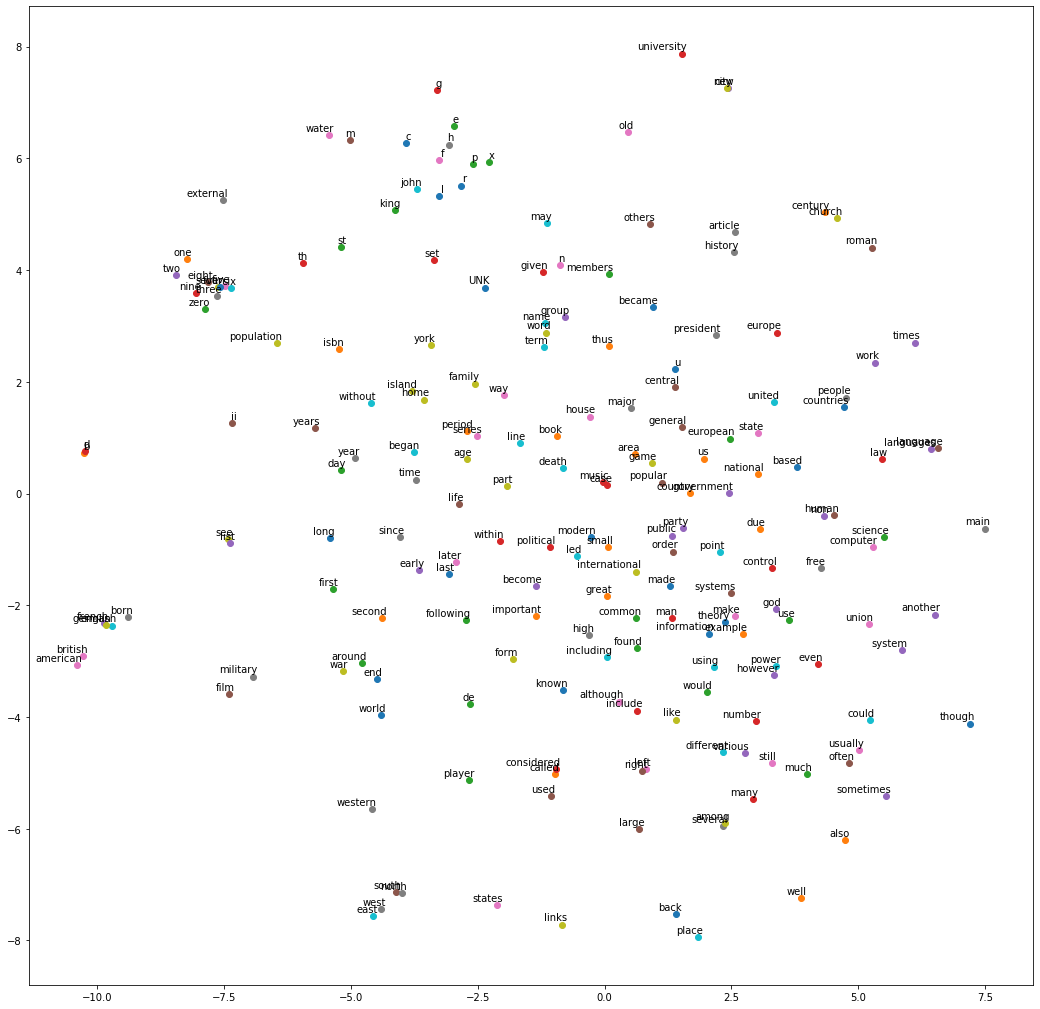

In [52]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 200
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocab[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [38]:
import tensorflow as tf
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [39]:
x = tf.placeholder(tf.int32, shape=[None])
E = tf.constant(np.array([[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,6]]))
embedded_x = tf.nn.embedding_lookup(E, x)
with tf.Session() as sess:
    print(sess.run(E))
    feed_dict = {x: [1,1,0,3]}
    print(sess.run(embedded_x, feed_dict=feed_dict))

[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]]
[[1 2 3]
 [1 2 3]
 [0 1 2]
 [3 4 5]]
